In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,precision_recall_curve
from sklearn.ensemble import RandomForestClassifier , StackingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import cross_val_score,GridSearchCV

# 한글 깨짐 방지
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'malgun Gothic'

In [2]:
# Train Test Spilt Data Load

train_df = pd.read_csv('./datasets/KOSDAQ_TRAIN_DATA.csv', index_col=0)
train_df = train_df.iloc[:,2:]
test_df = pd.read_csv('./datasets/KOSDAQ_TEST1_DATA.csv', index_col=0)
test_df = test_df.iloc[:,2:]

In [3]:
# Train Scaling 전 Data 분리하기

X_train = train_df.drop(columns=['label', '산업분류', '기업생애주기_Shake-Out',
       '기업생애주기_도입기', '기업생애주기_성숙기', '기업생애주기_성장기', '기업생애주기_쇠퇴기', '회계년도'], axis=1)
X_train_concat = train_df[['산업분류', '기업생애주기_Shake-Out',
       '기업생애주기_도입기', '기업생애주기_성숙기', '기업생애주기_성장기', '기업생애주기_쇠퇴기', '회계년도']]
y_train = train_df[['label']]

In [4]:
# Test Scaling 전 Data 분리하기
X_test = test_df.drop(columns=['label', '산업분류', '기업생애주기_Shake-Out',
       '기업생애주기_도입기', '기업생애주기_성숙기', '기업생애주기_성장기', '기업생애주기_쇠퇴기', '회계년도'], axis=1)
X_test_concat = test_df[['산업분류', '기업생애주기_Shake-Out',
       '기업생애주기_도입기', '기업생애주기_성숙기', '기업생애주기_성장기', '기업생애주기_쇠퇴기', '회계년도']]
y_test = test_df[['label']]

In [5]:
# Scaling

from sklearn.preprocessing import StandardScaler
# StandardScaler() Scaler객체 생성.
scaler = StandardScaler()
# 학습 데이터에 대해서 fit(), transform() 수행.
scaler.fit(X_train)
train_scaled_SS = scaler.transform(X_train)
# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
X_train_SS = pd.DataFrame(data = train_scaled_SS, columns=X_train.columns)

# 테스트 데이터에서는 다시 fit(), transform()이나 fit_transform()을 수행하지 않고 transform만 수행.
test_scaled_MM = scaler.transform(X_test)
# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
X_test_SS = pd.DataFrame(data = test_scaled_MM, columns=X_test.columns)

In [6]:
# Scaling Data와 결합

X_train_SS_1 = pd.concat([X_train_SS, X_train_concat, y_train], axis=1)
X_test_SS_1 = pd.concat([X_test_SS, X_test_concat, y_test], axis=1)

# 리샘플링 X
 - Feature 
['총자본증가율',
 '총자본순이익률',
 '자기자본순이익률',
 '매출원가대매출액비율',
 '금융비용대총비용비율',
 '1주당순이익',
 '1주당정상영업이익',
 '자기자본구성비율',
 '순운전자본비율',
 'CASHFLOW대총자본비율',
 '순운전자본회전률']

In [7]:
X_train_1 = X_train_SS_1[['총자본증가율',
 '총자본순이익률',
 '자기자본순이익률',
 '매출원가대매출액비율',
 '1주당순이익',
 '1주당정상영업이익',
 '자기자본구성비율',
 '순운전자본비율',
 'CASHFLOW대총자본비율',
 '순운전자본회전률']]
X_test_1 = X_test_SS_1[['총자본증가율',
 '총자본순이익률',
 '자기자본순이익률',
 '매출원가대매출액비율',
 '1주당순이익',
 '1주당정상영업이익',
 '자기자본구성비율',
 '순운전자본비율',
 'CASHFLOW대총자본비율',
 '순운전자본회전률']]
y_train_1 = X_train_SS_1[['label']]
y_test_1 = X_test_SS_1[['label']]

In [8]:
def model_basic(x_train, y_train, x_test, y_test): 
    models = [
        LogisticRegression(random_state=0),
        SVC(random_state=0),
        DecisionTreeClassifier(random_state=0),
        RandomForestClassifier(random_state=0),
        XGBClassifier(random_state=0),
        LGBMClassifier(random_state=0)
    ]

    rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


    for clf in models:
        clf = clf.fit(x_train, y_train)
    #1열:Train
        y_hat = clf.predict(x_train)
        results_train  = (round(accuracy_score(y_train,y_hat),4),round(roc_auc_score(y_train,y_hat),4))
    #2열:Test
        y_hat = clf.predict(x_test)
        results = (round(accuracy_score(y_test,y_hat),4),
                        round(precision_score(y_test,y_hat),4),
                        round(recall_score(y_test,y_hat),4),
                        round(f1_score(y_test,y_hat),4),
                        round(roc_auc_score(y_test,y_hat),4))

        rdict['model'].append(clf); 
        rdict['acc_train'].append(results_train[0])
        rdict['auc_train'].append(results_train[1])
        
        rdict['acc_test'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['AUC_test'].append(results[4])   

        confusion = confusion_matrix(y_test, y_hat)

        print(confusion)

    rdf_final = pd.DataFrame(data=rdict)
    return rdf_final

In [9]:
model_basic(X_train_1, y_train, X_test_1, y_test)

[[2374   13]
 [  16    2]]
[[2381    6]
 [  16    2]]
[[2347   40]
 [  13    5]]
[[2377   10]
 [  15    3]]
[[2373   14]
 [  15    3]]
[[2376   11]
 [  14    4]]


,model,acc_train,auc_train,acc_test,precision,recall,f1_score,AUC_test
0,LogisticRegression(random_state=0),0.9855,0.6388,0.9879,0.1333,0.1111,0.1212,0.5528
1,SVC(random_state=0),0.9884,0.6771,0.9909,0.2500,0.1111,0.1538,0.5543
2,DecisionTreeClassifier(random_state=0),1.0000,1.0000,0.9780,0.1111,0.2778,0.1587,0.6305
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,0.9896,0.2308,0.1667,0.1935,0.5812
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,0.9879,0.1765,0.1667,0.1714,0.5804
5,LGBMClassifier(random_state=0),1.0000,1.0000,0.9896,0.2667,0.2222,0.2424,0.6088


----------------------------

# 리샘플링 O

In [10]:
re_train_df = pd.read_csv('./datasets/KOSDAQ_TRAIN_DATA.csv', index_col=0)
re_train_df = re_train_df.iloc[:,2:]
re_test_df = pd.read_csv('./datasets/KOSDAQ_TEST1_DATA.csv', index_col=0)
re_test_df = re_test_df.iloc[:,2:]

In [11]:
# Train Scaling 전 Data 분리하기

X_train = re_train_df.drop(columns=['label', '산업분류', '기업생애주기_Shake-Out',
       '기업생애주기_도입기', '기업생애주기_성숙기', '기업생애주기_성장기', '기업생애주기_쇠퇴기', '회계년도'], axis=1)
X_train_concat = re_train_df[['산업분류', '기업생애주기_Shake-Out',
       '기업생애주기_도입기', '기업생애주기_성숙기', '기업생애주기_성장기', '기업생애주기_쇠퇴기', '회계년도']]
y_train = re_train_df[['label']]

In [12]:
# Test Scaling 전 Data 분리하기

X_test = re_test_df.drop(columns=['label', '산업분류', '기업생애주기_Shake-Out',
       '기업생애주기_도입기', '기업생애주기_성숙기', '기업생애주기_성장기', '기업생애주기_쇠퇴기', '회계년도'], axis=1)
X_test_concat = re_test_df[['산업분류', '기업생애주기_Shake-Out',
       '기업생애주기_도입기', '기업생애주기_성숙기', '기업생애주기_성장기', '기업생애주기_쇠퇴기', '회계년도']]
y_test = re_test_df[['label']]

In [13]:
# Scaling

from sklearn.preprocessing import StandardScaler
# StandardScaler() Scaler객체 생성.
scaler = StandardScaler()
# 학습 데이터에 대해서 fit(), transform() 수행.
scaler.fit(X_train)
train_scaled_SS = scaler.transform(X_train)
# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
X_train_SS = pd.DataFrame(data = train_scaled_SS, columns=X_train.columns)

# 테스트 데이터에서는 다시 fit(), transform()이나 fit_transform()을 수행하지 않고 transform만 수행.
test_scaled_MM = scaler.transform(X_test)
# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
X_test_SS = pd.DataFrame(data = test_scaled_MM, columns=X_test.columns)

In [14]:
# 스케일링 후 데이터 합치기

X_train_SS = pd.concat([X_train_SS,X_train_concat,y_train], axis=1)
X_test_SS = pd.concat([X_test_SS,X_test_concat, y_test], axis=1)

trian_test_df = pd.concat([X_train_SS, X_test_SS], axis=0)
trian_test_df.reset_index(drop=True, inplace=True)

In [16]:
# 회계년도 기준으로 데이터 스플릿

df_2011 = trian_test_df[trian_test_df['회계년도'] == '2011/12']
df_2012 = trian_test_df[trian_test_df['회계년도'] == '2012/12']
df_2013 = trian_test_df[trian_test_df['회계년도'] == '2013/12']
df_2014 = trian_test_df[trian_test_df['회계년도'] == '2014/12']
df_2015 = trian_test_df[trian_test_df['회계년도'] == '2015/12']
df_2016 = trian_test_df[trian_test_df['회계년도'] == '2016/12']
df_2017 = trian_test_df[trian_test_df['회계년도'] == '2017/12']
df_2018 = trian_test_df[trian_test_df['회계년도'] == '2018/12']
df_2019 = trian_test_df[trian_test_df['회계년도'] == '2019/12']

In [17]:
# 회계년도 기준으로 데이터 라벨 분리 작업

df_X_2011 = df_2011.drop(columns='label', axis=1)
df_y_2011 = df_2011[['label']]
df_X_2012 = df_2012.drop(columns='label', axis=1)
df_y_2012 = df_2012[['label']]
df_X_2013 = df_2013.drop(columns='label', axis=1)
df_y_2013 = df_2013[['label']]
df_X_2014 = df_2014.drop(columns='label', axis=1)
df_y_2014 = df_2014[['label']]
df_X_2015 = df_2015.drop(columns='label', axis=1)
df_y_2015 = df_2015[['label']]
df_X_2016 = df_2016.drop(columns='label', axis=1)
df_y_2016 = df_2016[['label']]
df_X_2017 = df_2017.drop(columns='label', axis=1)
df_y_2017 = df_2017[['label']]
df_X_2018 = df_2018.drop(columns='label', axis=1)
df_y_2018 = df_2018[['label']]
df_X_2019 = df_2019.drop(columns='label', axis=1)
df_y_2019 = df_2019[['label']]

In [30]:
# 랜덤언더샘플링 0.2 비율로 진행

from imblearn.under_sampling import RandomUnderSampler

X_samp_11, y_samp_11 = RandomUnderSampler(random_state=0,sampling_strategy=0.2).fit_resample(df_X_2011, df_y_2011)
X_samp_12, y_samp_12 = RandomUnderSampler(random_state=0,sampling_strategy=0.2).fit_resample(df_X_2012, df_y_2012)
X_samp_13, y_samp_13 = RandomUnderSampler(random_state=0,sampling_strategy=0.2).fit_resample(df_X_2013, df_y_2013)
X_samp_14, y_samp_14 = RandomUnderSampler(random_state=0,sampling_strategy=0.2).fit_resample(df_X_2014, df_y_2014)
X_samp_15, y_samp_15 = RandomUnderSampler(random_state=0,sampling_strategy=0.2).fit_resample(df_X_2015, df_y_2015)
X_samp_16, y_samp_16 = RandomUnderSampler(random_state=0,sampling_strategy=0.2).fit_resample(df_X_2016, df_y_2016)
X_samp_17, y_samp_17 = RandomUnderSampler(random_state=0,sampling_strategy=0.2).fit_resample(df_X_2017, df_y_2017)
X_samp_18, y_samp_18 = RandomUnderSampler(random_state=0,sampling_strategy=0.2).fit_resample(df_X_2018, df_y_2018)
X_samp_19, y_samp_19 = RandomUnderSampler(random_state=0,sampling_strategy=0.2).fit_resample(df_X_2019, df_y_2019)

In [31]:
# 언더샘플링한 데이터 결합 

X_samp = pd.concat([X_samp_11, X_samp_12, X_samp_13, X_samp_14, X_samp_15, X_samp_16, X_samp_17, X_samp_18, X_samp_19], axis=0)
y_samp = pd.concat([y_samp_11, y_samp_12, y_samp_13, y_samp_14, y_samp_15, y_samp_16, y_samp_17, y_samp_18, y_samp_19], axis=0)

trian_test_samp_df = pd.concat([X_samp, y_samp], axis=1)

In [33]:
# 회계년도 기준으로 다시 Split 진행

X_samp_train = trian_test_samp_df[trian_test_samp_df['회계년도'] <= '2017/12']
X_samp_test = trian_test_samp_df[(trian_test_samp_df['회계년도'] <= '2019/12') & (X_samp['회계년도'] >= '2018/12')]

In [ ]:
# train 라벨 분리

X_samp_train_1 = X_samp_train.drop(columns=['label', '회계년도'], axis=1)
y_samp_train_1 = X_samp_train[['label']]

# test 라벨 분리

X_samp_test_1 = X_samp_test.drop(columns=['label', '회계년도'], axis=1)
y_samp_test_1 = X_samp_test[['label']]

In [36]:
# 인덱스 초기화

X_samp_train_1.reset_index(drop=True, inplace=True)
X_samp_test_1.reset_index(drop=True, inplace=True)
y_samp_train_1.reset_index(drop=True, inplace=True)
y_samp_test_1.reset_index(drop=True, inplace=True)

In [37]:
# 오버샘플링 진행 by BorderlineSMOTE

from imblearn.over_sampling import BorderlineSMOTE

X_samp_2, y_samp_2 = BorderlineSMOTE(random_state=0,sampling_strategy=1).fit_resample(X_samp_train_1, y_samp_train_1)

In [38]:
# Train 과 Test 로 각각 데이터 결합

train_df = pd.concat([X_samp_2, y_samp_2], axis=1)
test_df = pd.concat([X_samp_test_1, y_samp_test_1], axis=1)

 - Feature 
['총자본증가율',
 '총자본순이익률',
 '자기자본순이익률',
 '매출원가대매출액비율',
 '1주당순이익',
 '1주당정상영업이익',
 '자기자본구성비율',
 '순운전자본비율',
 'CASHFLOW대총자본비율',
 '순운전자본회전률']

In [39]:
# Feature Selection 된 Feature만 추출

X_train = train_df[['총자본증가율',
 '총자본순이익률',
 '자기자본순이익률',
 '매출원가대매출액비율',
 '1주당순이익',
 '1주당정상영업이익',
 '자기자본구성비율',
 '순운전자본비율',
 'CASHFLOW대총자본비율',
 '순운전자본회전률']]
X_test = test_df[['총자본증가율',
 '총자본순이익률',
 '자기자본순이익률',
 '매출원가대매출액비율',
 '1주당순이익',
 '1주당정상영업이익',
 '자기자본구성비율',
 '순운전자본비율',
 'CASHFLOW대총자본비율',
 '순운전자본회전률']]
y_train = train_df[['label']]
y_test = test_df[['label']]

In [40]:
def model_basic(x_train, y_train, x_test, y_test): 
    models = [
        LogisticRegression(random_state=0),
        SVC(random_state=0),
        DecisionTreeClassifier(random_state=0),
        RandomForestClassifier(random_state=0),
        XGBClassifier(random_state=0),
        LGBMClassifier(random_state=0) 
    ]

    rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


    for clf in models:
        clf = clf.fit(x_train, y_train)
    #1열:Train
        y_hat = clf.predict(x_train)
        results_train  = (round(accuracy_score(y_train,y_hat),4),round(roc_auc_score(y_train,y_hat),4))
    #2열:Test
        y_hat = clf.predict(x_test)
        results = (round(accuracy_score(y_test,y_hat),4),
                        round(precision_score(y_test,y_hat),4),
                        round(recall_score(y_test,y_hat),4),
                        round(f1_score(y_test,y_hat),4),
                        round(roc_auc_score(y_test,y_hat),4))

        rdict['model'].append(clf); 
        rdict['acc_train'].append(results_train[0])
        rdict['auc_train'].append(results_train[1])
        
        rdict['acc_test'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['AUC_test'].append(results[4])   

        confusion = confusion_matrix(y_test, y_hat)

        print(confusion)

    rdf_final = pd.DataFrame(data=rdict)
    return rdf_final

In [41]:
model_basic(X_train, y_train, X_test, y_test)

[[76 14]
 [ 1 17]]
[[74 16]
 [ 2 16]]
[[78 12]
 [ 6 12]]
[[80 10]
 [ 2 16]]
[[82  8]
 [ 2 16]]
[[80 10]
 [ 2 16]]


,model,acc_train,auc_train,acc_test,precision,recall,f1_score,AUC_test
0,LogisticRegression(random_state=0),0.9178,0.9178,0.8611,0.5484,0.9444,0.6939,0.8944
1,SVC(random_state=0),0.9364,0.9364,0.8333,0.5000,0.8889,0.6400,0.8556
2,DecisionTreeClassifier(random_state=0),1.0000,1.0000,0.8333,0.5000,0.6667,0.5714,0.7667
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,0.8889,0.6154,0.8889,0.7273,0.8889
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,0.9074,0.6667,0.8889,0.7619,0.9000
5,LGBMClassifier(random_state=0),1.0000,1.0000,0.8889,0.6154,0.8889,0.7273,0.8889


In [42]:
# 진짜 적합
from sklearn.preprocessing import Binarizer
import time
start = time.time()

best_lr = XGBClassifier()
best_lr.fit(X_train,y_train)  


pred_lr = best_lr.predict(X_test)
pred_prob_lr = best_lr.predict_proba(X_test)[:,1].reshape(-1,1)
# binarizer = Binarizer(threshold=0.49).fit(pred_prob_lr) 
# custom_lr = binarizer.transform(pred_prob_lr)


end = time.time()
print(f"모델적합 예측 시간: {end-start}")

모델적합 예측 시간: 0.1300060749053955


총자본순이익률           0.615617
순운전자본회전률          0.080483
CASHFLOW대총자본비율    0.070335
1주당정상영업이익         0.050926
자기자본구성비율          0.037598
순운전자본비율           0.035109
매출원가대매출액비율        0.028494
총자본증가율            0.028268
자기자본순이익률          0.028031
1주당순이익            0.025141
dtype: float32


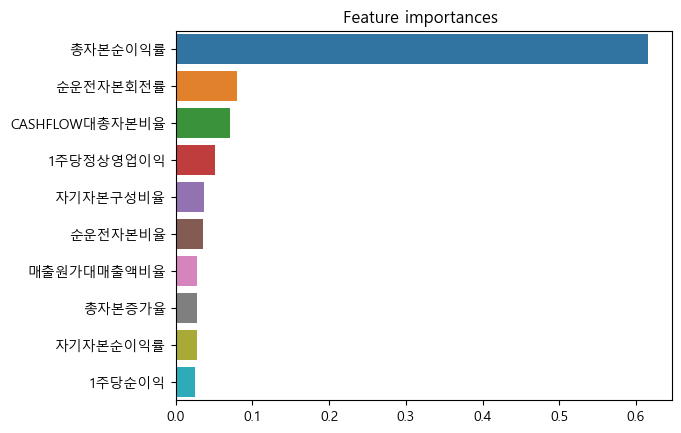

In [43]:
importance= pd.Series(index=X_train.columns,data=best_lr.feature_importances_)
ft_im = importance.sort_values(ascending=False)
print(ft_im)


#plt.figure(figsize=(8,6))
plt.title("Feature importances ")
sns.barplot(x=ft_im,y=ft_im.index)
plt.show()

# 하이퍼 파라미터 튜닝

# 1. LogisticRegression

In [44]:
### LogisticRegression

from sklearn.model_selection import GridSearchCV
param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2', 'elasticnet']
}

estimator = LogisticRegression(n_jobs=-1)

In [45]:
# define grid_search
lr_grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid, 
                           n_jobs=-1, 
                           verbose=0
                          )

# fit with (x_train, y_train)
lr_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(n_jobs=-1), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [46]:
# 최적 하이퍼 파라미터 조합
lr_grid_search.best_params_

{'C': 10, 'penalty': 'l2'}

# 2. SVC

In [47]:
### 이부분만 수정하면 됨!(param_grid, estimator)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_grid = {
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.001, 0.01, 0.1, 1, 10]
}

estimator = SVC()

In [48]:
# define grid_search
svc_grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid, 
                           n_jobs=-1, 
                           verbose=0
                          )

# fit with (x_train, y_train)
svc_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [49]:
# 최적 하이퍼 파라미터 조합
svc_grid_search.best_params_

{'C': 10, 'kernel': 'rbf'}

# 3. DecisionTreeClassifier

In [50]:
### 이부분만 수정하면 됨!(param_grid, estimator)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_grid = {
        'max_depth':[2,3,4,5,6,7,8],
        'min_samples_leaf':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
}

estimator = DecisionTreeClassifier()

In [51]:
# define grid_search
lr_grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid, 
                           n_jobs=-1, 
                           verbose=0
                          )

# fit with (x_train, y_train)
lr_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                              15, 16, 17, 18, 19, 20]})

In [52]:
# 최적 하이퍼 파라미터 조합
lr_grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 6}

# 4. RandomForestClassifier

In [53]:
### 이부분만 수정하면 됨!(param_grid, estimator)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_grid = {
        'criterion': ['entropy', 'gini'],
        'max_depth': [6,7,8],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [4,5],
        'min_samples_split': [7,8],
        'n_estimators': [20]
        }

estimator = RandomForestClassifier(n_jobs=-1)

In [54]:
# define grid_search
rf_grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid,
                           n_jobs=-1, 
                           verbose=0
                          )

# fit with (x_train, y_train)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [6, 7, 8],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [4, 5],
                         'min_samples_split': [7, 8], 'n_estimators': [20]})

In [55]:
# 최적 하이퍼 파라미터 조합
rf_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 7,
 'n_estimators': 20}

# 5. XGBClassifier

In [56]:
### 이부분만 수정하면 됨!(param_grid, estimator)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_grid = {
        'n_estimators':[40,43,46,50],
        'learning_rate':[0.005,0.008,0.01,0.03],
        'max_depth' : [1,2,3,4]
}

estimator = XGBClassifier(n_jobs=-1)

In [57]:
# define grid_search
xgb_grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid, 
                           n_jobs=-1, 
                           verbose=0
                          )

# fit with (x_train, y_train)
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.008, 0.01, 0.03],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [40, 43, 46, 50]})

In [58]:
# 최적 하이퍼 파라미터 조합
xgb_grid_search.best_params_

{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 40}

# 6. LGBMClassifier

In [59]:
### 이부분만 수정하면 됨!(param_grid, estimator)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_grid = {
        'n_estimators':[40,43,46,50],
        'learning_rate':[0.005,0.008,0.01,0.03],
        'max_depth' : [1,2,3,4]
}

estimator = LGBMClassifier(n_jobs=-1)

In [60]:
# define grid_search
lgbm_grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid, 
                           n_jobs=-1, 
                           verbose=0
                          )

# fit with (x_train, y_train)
lgbm_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.008, 0.01, 0.03],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [40, 43, 46, 50]})

In [61]:
# 최적 하이퍼 파라미터 조합
lgbm_grid_search.best_params_

{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 46}

# 하이퍼 파라미터 끝

In [62]:
def model_basic(x_train, y_train, x_test, y_test): 
    models = [
        LogisticRegression(C = 10, penalty = 'l2', random_state=0),
        SVC(C = 10, kernel = 'rbf', random_state=0),
        DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 6, random_state=0),
        RandomForestClassifier(random_state=0, criterion = 'entropy', max_depth = 8, max_features = 'auto', min_samples_leaf = 5,
                                min_samples_split = 7, n_estimators = 20),
        XGBClassifier(learning_rate = 0.03, max_depth = 3, n_estimators = 40, random_state=0),
        LGBMClassifier(learning_rate = 0.03, max_depth = 4, n_estimators = 46, random_state=0)
    ]

    rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


    for clf in models:
        clf = clf.fit(x_train, y_train)
    #1열:Train
        y_hat = clf.predict(x_train)
        results_train  = (round(accuracy_score(y_train,y_hat),4),round(roc_auc_score(y_train,y_hat),4))
    #2열:Test
        y_hat = clf.predict(x_test)
        results = (round(accuracy_score(y_test,y_hat),4),
                        round(precision_score(y_test,y_hat),4),
                        round(recall_score(y_test,y_hat),4),
                        round(f1_score(y_test,y_hat),4),
                        round(roc_auc_score(y_test,y_hat),4))

        rdict['model'].append(clf); 
        rdict['acc_train'].append(results_train[0])
        rdict['auc_train'].append(results_train[1])
        
        rdict['acc_test'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['AUC_test'].append(results[4])   

        confusion = confusion_matrix(y_test, y_hat)

        print(confusion)

    rdf_final = pd.DataFrame(data=rdict)
    return rdf_final

In [63]:
model_basic(X_train, y_train, X_test, y_test)

[[76 14]
 [ 1 17]]
[[80 10]
 [ 4 14]]
[[77 13]
 [ 1 17]]
[[78 12]
 [ 3 15]]
[[72 18]
 [ 2 16]]
[[75 15]
 [ 2 16]]


,model,acc_train,auc_train,acc_test,precision,recall,f1_score,AUC_test
0,"LogisticRegression(C=10, random_state=0)",0.9178,0.9178,0.8611,0.5484,0.9444,0.6939,0.8944
1,"SVC(C=10, random_state=0)",0.9654,0.9654,0.8704,0.5833,0.7778,0.6667,0.8333
2,"DecisionTreeClassifier(max_depth=5, min_sample...",0.9430,0.9430,0.8704,0.5667,0.9444,0.7083,0.9000
3,"(DecisionTreeClassifier(criterion='entropy', m...",0.9636,0.9636,0.8611,0.5556,0.8333,0.6667,0.8500
4,"XGBClassifier(base_score=None, booster=None, c...",0.9374,0.9374,0.8148,0.4706,0.8889,0.6154,0.8444
5,"LGBMClassifier(learning_rate=0.03, max_depth=4...",0.9430,0.9430,0.8426,0.5161,0.8889,0.6531,0.8611


# 튜닝하기전 모델 결과값이 더 좋음